### Data integration using SCANORAMA

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import hdf5plugin
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import scanpy.external as sce
import scanorama
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
## 8687 genes
H5AD = "./data/4_concatenated_h5ad/lung_cancer_concat_data_v3.h5ad"
# H5AD_INTEGRATED = "./data/6_integrated_h5ads/lung_cancer_scanorama_all_genes.h5ad"

# H5AD_INTEGRATED = "./data/6_integrated_h5ads/lung_cancer_scanorama_3000_hvgs.h5ad"

# H5AD_INTEGRATED = "./data/6_integrated_h5ads/lung_cancer_scanorama_top_500_mlc_genes.h5ad"

H5AD_INTEGRATED = "./data/6_integrated_h5ads/lung_cancer_scanorama_top_300_mlc_genes.h5ad"

In [3]:
IMPORTANT_GENES = "./data/5_csv_dataframes/ctype_condition_multilabel_features_v3.csv"

### Data preprocessor function

In [4]:
def data_preprocessor(adata):
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
#     sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True)
    adata.raw = adata
    sc.pp.scale(adata, max_value=10)
    sc.pp.pca(adata)
    return adata

### Read and preprocess dataset

In [5]:
imp_genes_df = pd.read_csv(IMPORTANT_GENES)
top500_df = pd.DataFrame(imp_genes_df.loc[:299, 'feature'])
top500_gene_list = top500_df['feature'].tolist()
top500_gene_list

['NKG7',
 'HSPA1A',
 'CCL4',
 'GZMH',
 'RGS1',
 'CCL5',
 'CTSW',
 'HSPE1',
 'TYROBP',
 'HSPA1B',
 'GZMB',
 'FCGR3A',
 'HSP90AA1',
 'IL7R',
 'CD3D',
 'CD74',
 'CST7',
 'FGFBP2',
 'GNLY',
 'HSPB1',
 'CD3E',
 'CST3',
 'CFD',
 'JUN',
 'PRF1',
 'KLRK1',
 'SLC11A1',
 'AIF1',
 'IL32',
 'FCER1G',
 'ANXA1',
 'DNAJB1',
 'PLAC8',
 'S100A4',
 'CXCR4',
 'DNAJA1',
 'SPP1',
 'HSP90AB1',
 'LTB',
 'KLF2',
 'CD2',
 'CRTAM',
 'SPON2',
 'MIF',
 'CCR7',
 'HSPH1',
 'CD68',
 'CD79A',
 'SPI1',
 'S1PR1',
 'FGR',
 'APOC1',
 'CD4',
 'PLEK',
 'HSPA8',
 'HSPD1',
 'FTL',
 'GAPDH',
 'BIN2',
 'LYZ',
 'SERPINA1',
 'MGST1',
 'CX3CR1',
 'B2M',
 'C1QB',
 'DUSP4',
 'RGS2',
 'MS4A4A',
 'RASGRP2',
 'APOE',
 'AES',
 'MRC1',
 'MYL12A',
 'OLR1',
 'ID2',
 'PTPRC',
 'RPL28',
 'MS4A7',
 'PTMS',
 'EMP2',
 'CD52',
 'RPS21',
 'ITGB2',
 'LEF1',
 'FTH1',
 'RPLP1',
 'KRT18',
 'C1QA',
 'GPR183',
 'MARCO',
 'CEBPD',
 'PTGER2',
 'SLAMF7',
 'LITAF',
 'EEF1A1',
 'TNFRSF9',
 'RAB31',
 'LST1',
 'HOPX',
 'UBB',
 'PTMA',
 'MDK',
 'CCND3',
 'RPL

In [6]:
merged_adata = sc.read_h5ad(H5AD)
merged_adata = merged_adata[:, merged_adata.var_names.isin(top500_gene_list)]
merged_adata = data_preprocessor(merged_adata)
merged_adata

AnnData object with n_obs × n_vars = 45228 × 300
    obs: 'tissue', 'cell_type', 'batch'
    var: 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

### Split per batch into new objects for initial data.

In [7]:
batches = merged_adata.obs['batch'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = merged_adata[merged_adata.obs['batch'] == batch,]

alldata

{'0': View of AnnData object with n_obs × n_vars = 1275 × 300
     obs: 'tissue', 'cell_type', 'batch'
     var: 'mean', 'std'
     uns: 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs',
 '1': View of AnnData object with n_obs × n_vars = 31608 × 300
     obs: 'tissue', 'cell_type', 'batch'
     var: 'mean', 'std'
     uns: 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs',
 '2': View of AnnData object with n_obs × n_vars = 12345 × 300
     obs: 'tissue', 'cell_type', 'batch'
     var: 'mean', 'std'
     uns: 'log1p', 'pca'
     obsm: 'X_pca'
     varm: 'PCs'}

### Integrate data using SCANORAMA

In [8]:
adatas = list(alldata.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

Found 300 genes among all datasets
[[0.         0.54745098 0.06666667]
 [0.         0.         0.27614419]
 [0.         0.         0.        ]]
Processing datasets (0, 1)
Processing datasets (1, 2)


In [9]:
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object, create a new object first
adata_all_scanorama = merged_adata.copy()
adata_all_scanorama.obsm["Scanorama"] = all_s

(45228, 50)


In [10]:
adata_all_scanorama

AnnData object with n_obs × n_vars = 45228 × 300
    obs: 'tissue', 'cell_type', 'batch'
    var: 'mean', 'std'
    uns: 'log1p', 'pca'
    obsm: 'X_pca', 'Scanorama'
    varm: 'PCs'

### Calculate UMAP using the SCANORAMA embedding

In [11]:
#umap
sc.pp.neighbors(adata_all_scanorama, use_rep = "Scanorama")
sc.tl.umap(adata_all_scanorama)

### Plot UMAP for sanity check (color by: batch and cell type)

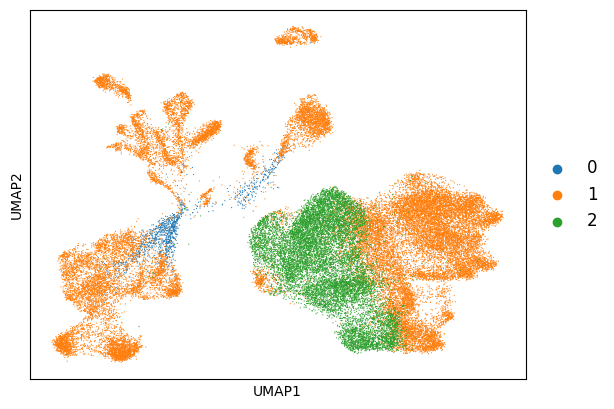

In [12]:
sc.pl.umap(adata_all_scanorama, color="batch", legend_fontsize=12, legend_fontoutline=2, 
           title='', show=False)

# sc.pl.umap(adata_all_scanorama, color='batch', add_outline=True,
#                legend_fontsize=12, legend_fontoutline=2,frameon=True,
#                title='', palette='Set1', show=False)

plt.savefig('./umap_batches_scanorama_top_300_mlc_map_like.png', dpi=600, bbox_inches='tight')

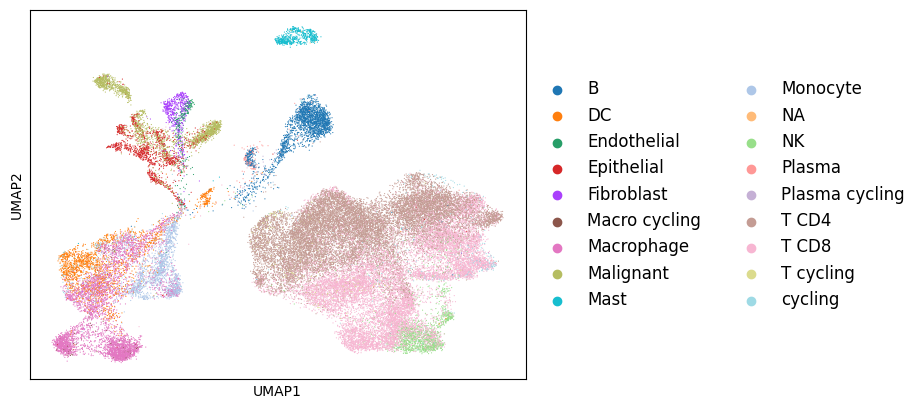

In [13]:
sc.pl.umap(adata_all_scanorama, color="cell_type", legend_fontsize=12, legend_fontoutline=2, 
           title='', show=False)

# sc.pl.umap(adata_all_scanorama, color='cell_type', add_outline=True,
#                legend_fontsize=12, legend_fontoutline=2,frameon=True,
#                title='', palette='tab20', show=False)

plt.savefig('./umap_cell_type_scanorama_top_300_mlc_map_like.png', dpi=600, bbox_inches='tight')

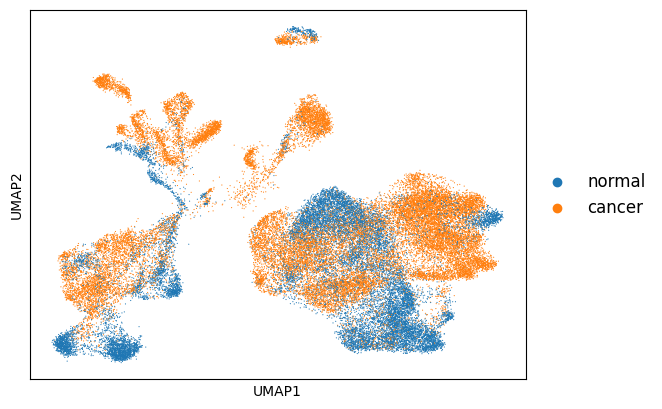

In [14]:
sc.pl.umap(adata_all_scanorama, color="tissue", legend_fontsize=12, legend_fontoutline=2, 
           title='', show=False)

# sc.pl.umap(adata_all_scanorama, color='tissue', add_outline=True,
#                legend_fontsize=12, legend_fontoutline=2,frameon=True,
#                title='', palette='viridis', show=False)

plt.savefig('./umap_conditions_scanorama_top_300_mlc.png', dpi=600, bbox_inches='tight')

### Write integrated dataset to disk

In [15]:
adata_all_scanorama.write_h5ad(
    H5AD_INTEGRATED,
    compression=hdf5plugin.FILTERS["zstd"]
)